<H1>13F Position Analysis</H1>

The following is the analysis of latest filing (as of 4/30/2015) of Pershing Square Capital Management. The data is public and is avilable from SEC Edgar website. This is a very basic example. More sophisticated analysis can be performed, particularly when more detailed position data is availble. 

<h2>Disclaimer</h2>
This notebook shows the types of analysis that can be peformed. Market and holdings data used in the report has been obtained from free resources and is not guaranteed to be correct. 
<h2>Basic SetUp</h2>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
import hfrisk as hf
from IPython.display import display, HTML
%matplotlib inline

<H2>Getting Time Series</H2>
<br/>
Here are a couple of functions to get time series data for all stocks in the portfolio using yahoo finance. However, for performance reasons, I saved the retreived data in csv files.

In [3]:
def get_stock_history_from_yahoo(symbol,startdate, enddate, dopct=False):
    """
        Get stock history from Yahoo
        symbol - stock symbol (e.g. YHOO,TSLA,MSFT)
        startdate - start date (e.g. 2015-01-01)
        enddate - end date (eg.g. 2015-05-31
        dopct - if True will convert price values to daily percent changes)
    """
    
    share = Share(symbol)
    tsdict = share.get_historical(startdate,enddate)
    df = pd.DataFrame(tsdict)
    df['Price'] = [float(x) for x in df['Adj_Close']]
    df = df.sort(['Date'])    
    df.index = df['Date']
    df = df['Price']
    if (dopct):
        df = df.pct_change()
        df = df[1:]
    return df
    
def get_port_ts_from_yahoo(port,startdate,enddate):
    """
        Builds a data frame with return series of stocks for a given portfolio
    """
    
    gethist = lambda s : get_stock_history_from_yahoo(s,startdate,enddate,True)
    allts = [gethist (symbol) for symbol in port['Symbol']]
    
    N = len(allts)
    if (N > 0):
        res = pd.DataFrame(allts[0])
        symbol = port.irow(0)['Symbol']
      
        res.columns = [symbol];
        for i in range(1,N):
            tsi = pd.DataFrame(allts[i])
            symbol = port.irow(i)['Symbol']
            tsi.columns = [symbol];
            res = pd.concat([res,tsi],axis=1,join='inner')
                
        
        return res
    else:
        return []

In [6]:
port = pd.DataFrame.from_csv("data/pershingport.csv")
HTML(port.to_html())

,Name,CUSIP,Shares,Symbol,Value,Industry,Weight
0,ACTAVIS PLC,G0083B108,1348358.0,ACT,4.012980e+08,HEALTHCARE,0.026806
1,AIR PRODS & CHEMS INC,009158106,20549076.0,APD,3.108664e+09,BASIC MATERIALS,0.207655
2,CANADIAN PAC RY LTD,13645T100,13940890.0,CP,2.547001e+09,SERVICES,0.170136
3,HOWARD HUGHES CORP,44267D107,3568017.0,HHC,5.531140e+08,FINANCIAL,0.036947
4,PLATFORM SPECIALTY PRODS COR,72766Q105,42737394.0,PAH,1.096642e+09,BASIC MATERIALS,0.073254
5,RESTAURANT BRANDS INTL INC,76131D103,38003984.0,QSR,1.459733e+09,FINANCIAL,0.097508
6,VALEANT PHARMACEUTICALS INTL,91911K102,19473933.0,VRX,3.867913e+09,HEALTHCARE,0.258371
7,ZOETIS INC,98978V103,41823145.0,ZTS,1.935993e+09,HEALTHCARE,0.129322


<img src="images/hlf.png"/>
<h3>Herbalife</h3>
<p>
The above portfolio represents only long position of Pershing Square (as required by SEC). It's well known that Bill Ackman had at that point int ime a big short against Herbalife. We don't have information about the size of the short but will assume allocation equal to half of the long portfolio value.
</p>
Herbalife stock symbol is HLF.

In [8]:
totPortValue = port['Value'].sum()
hlf = Share('HLF')
"""
get latest price
"""
hlfprice = float(hlf.get_price())
hlfprice 
hlfshares = -0.5 * totPortValue / hlfprice

d = {'Name':'Herbalife',
     'CUSIP':'NA',
     'Shares':hlfshares,
     'Symbol':'HLF',
     'Value':totPortValue * -0.5,
     'Industry':'PERSONAL PRODUCTS',
     'Weight':-0.5}

#we add spx for various analysis
spxd = {'Name':'S&P 500',
     'CUSIP':'NA',
     'Shares':hlfshares,
     'Symbol':'SPX',
     'Value':totPortValue * -0.5,
     'Industry':'INDEX',
     'Weight':0}

port = port.append(d,ignore_index=True)

port = port.append(spxd,ignore_index=True)
HTML(port.to_html())

,Name,CUSIP,Shares,Symbol,Value,Industry,Weight
0,ACTAVIS PLC,G0083B108,1.348358e+06,ACT,4.012980e+08,HEALTHCARE,0.026806
1,AIR PRODS & CHEMS INC,009158106,2.054908e+07,APD,3.108664e+09,BASIC MATERIALS,0.207655
2,CANADIAN PAC RY LTD,13645T100,1.394089e+07,CP,2.547001e+09,SERVICES,0.170136
3,HOWARD HUGHES CORP,44267D107,3.568017e+06,HHC,5.531140e+08,FINANCIAL,0.036947
4,PLATFORM SPECIALTY PRODS COR,72766Q105,4.273739e+07,PAH,1.096642e+09,BASIC MATERIALS,0.073254
5,RESTAURANT BRANDS INTL INC,76131D103,3.800398e+07,QSR,1.459733e+09,FINANCIAL,0.097508
6,VALEANT PHARMACEUTICALS INTL,91911K102,1.947393e+07,VRX,3.867913e+09,HEALTHCARE,0.258371
7,ZOETIS INC,98978V103,4.182314e+07,ZTS,1.935993e+09,HEALTHCARE,0.129322
8,Herbalife,NA,-1.228488e+08,HLF,-7.485179e+09,PERSONAL PRODUCTS,-0.500000
9,S&P 500,NA,-1.228488e+08,SPX,-7.485179e+09,INDEX,0.000000


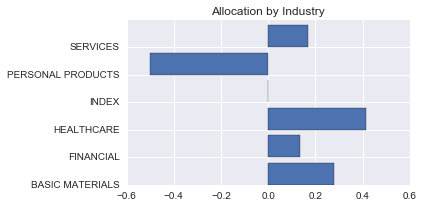

In [10]:
plt.figure(figsize=(6,3))
groupByIndustry = port.groupby('Industry')
tot = groupByIndustry.sum()
w_ind = tot['Weight'].values
l = len(w_ind)
plt.barh(np.arange(l),w_ind)
plt.yticks(np.arange(l),tot.index)
plt.title('Allocation by Industry')
plt.tight_layout()

<h2>Get Portfolio Time Series</h2>

In [13]:
#portTS = GetPortTSFromYahoo(port,'2001-06-01','2015-05-31')
#normally we would get portfolio time series fro yahoo using the function call shown above. 
#For performance issues we saved the data into CSV file 
port_ts = pd.DataFrame.from_csv("data/port_ts.csv")

<h2>Quick Snapshot of the correlation matrix</h2>

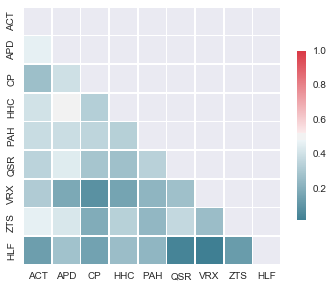

In [14]:
def plot_corr_matrix(cr):
    """
        Display a heatmpa of correlation matrix
    """
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    mask = np.zeros_like(cr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(cr, mask=mask,cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})
   
f, ax = plt.subplots(figsize=(5, 5))
plot_corr_matrix(port_ts.corr())
f.tight_layout()

<h2>HLF Correlations</h2>
<br>
We assumed that HLF is a big short that is equal to 50% of the long position. It's therefore important to analyze the correlations of HKF to other stocks in the portfolio.

In [15]:
cr = port_ts.corr()
hlfcorr = cr['HLF']
N = len(hlfcorr)
avgcorr = (hlfcorr.sum()-1)/(N-1)
str.format("Average Correlation of HLF to other stocks i portflio {0:0.2%}",avgcorr)

'Average Correlation of HLF to other stocks i portflio 15.95%'

Low correlation implies that short position does not reduce the overall risk of the portfolio but rather introduces another rather large source of risk.

<h2>Regime Analysis</h2>
<article>
We build a simplified regime model. 
First we look at the historical daily returns of S&P 500</article>

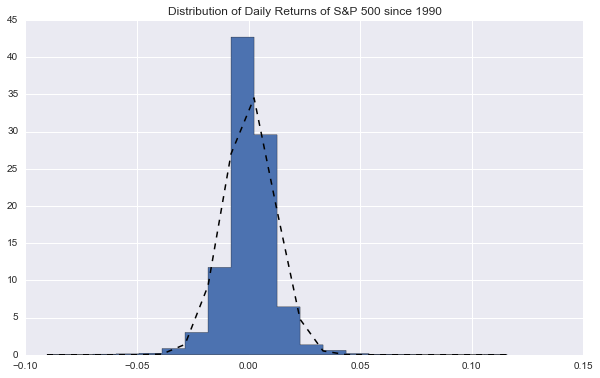

In [18]:

#spx = GetStockHistoryFromYahoo("^GSPC","1990-01-01","2015-05-31",dopct=True)
#get csv from presaved csv file
spx = pd.Series.from_csv("data/spx.csv")
f, ax = plt.subplots(figsize=(10, 6))
mu = np.mean(spx)
sigma = np.std(spx)

n, bins, patches = pl.hist(spx, 20, normed=1, histtype='stepfilled')
y = pl.normpdf(bins,mu,sigma)

pl.plot(bins,y,'k--',linewidth=1.5)
pl.title("Distribution of Daily Returns of S&P 500 since 1990")

We then take out top 1% and botoom 1% of the daily returns and then calculate mean and standard deviation of S&P 500 daily returns in the 98% of the daily returns..

We then define regimes as follows
<UL>
<LI><B>Normal</B> - within 1 standard deviations</LI>
<LI><B>Flight to Quality (FTQ)</B> - return is lower than -1 standard deviations</LI>
<LI><B>Bull Market (BM)</B> - return is higher than 1 standard deviations</LI>
</UL>
<br>
Since we consider 1 standard deviation band to be "normal", the normal regime should appear about 67% of the time. 
<br>
Obviously this is very crude regime model. Normally you should use at least several market factors in order to identify the regimes. I use simplified model for demo purposes only.

In [21]:
#get rid of 1%ers
spxsorted = spx.copy()
spxsorted.sort_values(inplace=True)
T = len(spxsorted)
idxlow = int(0.01 * T)
idxhigh = int(0.99*T)
#calculate distribution stats
spxrobust = spxsorted.values[idxlow:idxhigh]
spxdailyvol = np.std(spxrobust)
mu = np.mean(spxrobust)
#standardize the values
z=(spx.values - mu) / spxdailyvol

#identify regimes
regimes = np.array(['Normal' for i in range(T)])
regimes[z <= -1]='FTQ'
regimes[z >= 1]= 'BM'

regimeDF = pd.DataFrame(regimes,columns=['Regime'], index=spx.index)
regimeDF['SPX'] = spx.values;

g = regimeDF.groupby('Regime')

regimeStats = g.mean()
regimeStats['STD'] = g.std().values
regimeStats['T'] = g.count()['SPX'].values
regimeStats.columns = ['MEAN','STD','T']

#calculate modified time series matrix that now includes regimes and S&P 500 performance.
portTS2 = pd.concat([port_ts,regimeDF],axis=1,join='inner')



The following table shows summary of performance of S&P 500 in the three regimes

In [22]:
HTML(regimeStats.to_html())

,MEAN,STD,T
Regime,,,
BM,0.017369,0.009837,909
FTQ,-0.017447,0.009883,917
Normal,0.000523,0.004562,4576


Now that we have basic definitions of market regimes. We can estimate how the portfolio would perform (on average) in each of the regimes. Pleas note that more sophisticated regime model would generally be used in real life analysis

<b>Transition Matrix</b>
<br>
In order to understand how the regime model works it's helpfu; to visualize transition matrix among the regimes. The following function calculates transition matrix and return dictionary and dataframe representing the data.

In [24]:
import numpy as np
from collections import Counter


def calc_txn_matrix(series):
    """
        Calculate transition matrix from series of states
    """
    z = list(zip(series,series[1:]))
    keys = set(series)
    keyarray = list(keys)
    states = Counter(series)
    N = len(keys)
    stateCounter = {}
    for k in keys:
        for k2 in keys:
            stateCounter[(k,k2)] = 0
        
    for t in z:
        if t in stateCounter:
            stateCounter[t] = stateCounter[t] + 1
        else:
            stateCounter[t] = 1
   
    txnMatrix = {}
    txnArray = np.zeros((N,N))
    for t in stateCounter:
       a,b = t
       txnMatrix[t] = float(stateCounter[t]) / float(states[a])
   
    for i in range(N):
        for j in range(N):
            t = (keyarray[i],keyarray[j])
            txnArray[i,j] = txnMatrix[t]
       
      
    return txnMatrix, pd.DataFrame(data=txnArray,index=keyarray,columns=keyarray)


#Calculate the matrix
Txn,TxnDF = calc_txn_matrix(regimes)
regimes = regimeDF['Regime'].values
regimeNames = TxnDF.columns

Transition Matrix is represented below. We can see that the two extreme regimes are not very likely to happen or to persist. There is only 8.5% chance of staing in FTQ regime for two days in a row and 5.38% chance of staing in Bull Market regime for two days in a row.

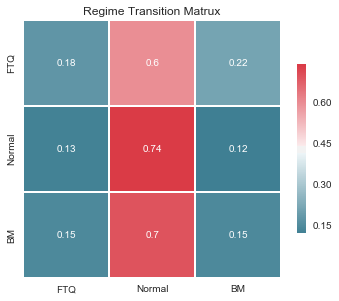

In [25]:
f, ax = plt.subplots(figsize=(5, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(TxnDF, cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Regime Transition Matrux')
f.tight_layout()

<h3>Interpreting Transition Matrix</h3>
The data is presented by row (the total should add up to 1). So if the current market regime Normal you have 13% chance of going to Flight to Quality, 12% chance into Bull Market and 74% chance of staying in normal regime.

<h3>
Performance by Regime
</h3>
We calculate expected performance of the portfolio based on average return of stckc in each market regime. 

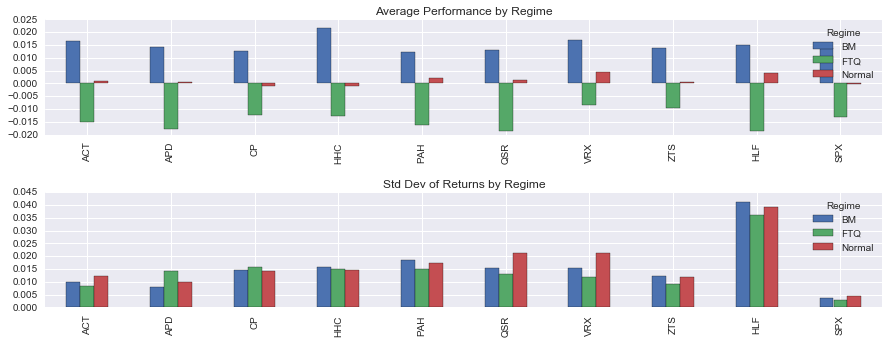

In [26]:
g = portTS2.groupby('Regime')
retByRegime = g.mean()
regimes = retByRegime.index

stdByRegime = g.std()

f,ax = plt.subplots(figsize=(15,5))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

f.subplots_adjust(wspace=0.25, hspace=0.50, top=0.85, bottom=0.05)
names = retByRegime.columns
colids = np.array(range(len(names)))
colors = ['r','g','y']

retByRegime.transpose().plot(kind='bar',ax=ax1,title='Average Performance by Regime')
stdByRegime.transpose().plot(kind='bar',ax=ax2,title='Std Dev of Returns by Regime')

<h3>Peformance of Portfolio by Regime</h3>

In [27]:
#calculate expected return by regime
w = np.matrix(port['Weight'].values)
R = np.matrix(retByRegime)
ER = np.array(w*R.transpose())

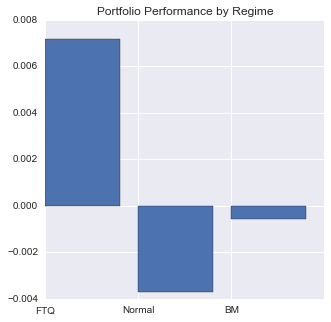

In [28]:
portPF = pd.DataFrame(columns=TxnDF.index,data=ER)
plt.subplots(figsize=(5,5))
plt.bar(np.arange(3),ER[0])
plt.xticks(np.arange(3),regimeNames)
plt.title('Portfolio Performance by Regime')

<H3>Regime Based Simulation</H3>
First we analyze correlation among the stocks in different regimes


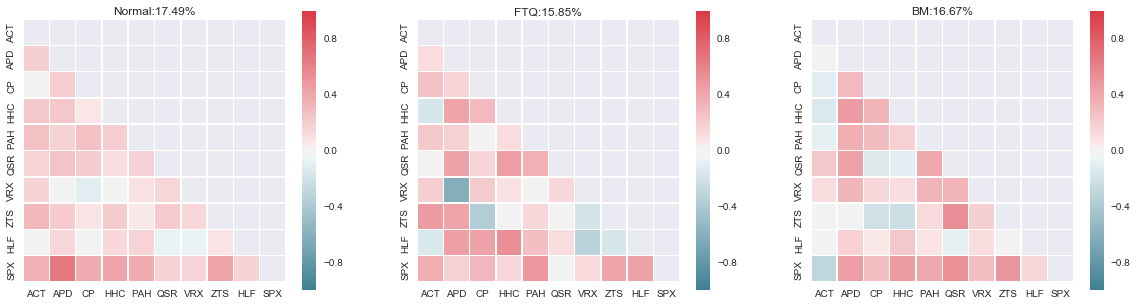

In [30]:
R = len(regimeNames)
def avg_corr(cr):
    """
        calculate avg correlation from correlation matrix
    """
    N = len(cr)
    return(cr.sum().sum()-N)/(N*N - N)

plt.subplots(figsize=(20, 10))
covariances = {}
means = {}
cmap = sns.diverging_palette(220, 10, as_cmap=True)
for (regime,i) in zip(['Normal','FTQ','BM'],np.arange(R)):
    idx = portTS2['Regime'] == regime
    subts = portTS2[idx]
    cr = subts.corr()
    cv = subts.cov()
    means[regime]= subts.mean()
    covariances[regime]=cv
    plt.subplot(130+(i+1))
    plot_corr_matrix(cr)
    title = str.format("{0}:{1:0.2%}",regime,avg_corr(cr))
    plt.title(title)



<b><i>Interesting to note is that the correlations seem to be lower in FTQ regime. </i></b>

We can use regime information to simulate portfolio performance over time. We do that by simulating transition from one state to another using transition matrix calculated above. In each state we use covariance matrix of assets to simulate performance using multi-variable normal distribution. 


In [36]:
def get_next_regime(txnmatrix,regime,u):
    """
        Gets next regime using specified Transition Matrix data frame
    """
    probs = txnmatrix[regime]
    probsDFsorted = probs.sort_values(ascending=False)
    probssorted = list(probsDFsorted.cumsum())
    try:
        res = [n for n,i in enumerate(probssorted) if i >= u][0]
    except:
        res = len(probs) - 1.0
    return probsDFsorted.index[res]

In [43]:
#now simulate regimes
w = port.Weight.values
W = w[:N]
np.append(w,[0])
Wm = np.matrix(w) #weight matrix
Trials = 1000
Days = 250

cumrets = np.zeros((Trials,1))
for i in range(Trials):
    rets = np.zeros((Days,1))
    startRegime = 'Normal'
    for t in range(Days):
        u = np.random.rand()
        nextRegime = get_next_regime(TxnDF,startRegime,u)
        startRegime = nextRegime
        cv = covariances[nextRegime]
        mu = means[nextRegime]
        U = np.matrix(np.random.multivariate_normal(mu,cv)).transpose()
        R = Wm * U
        rets[t] = R
        
        
        cp=np.cumprod(rets+1)
        cumrets[i] = cp[-1]-1.0

/Users/Aleksey/anaconda3/lib/python3.5/site-packages/pandas/indexes/base.py:1264: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


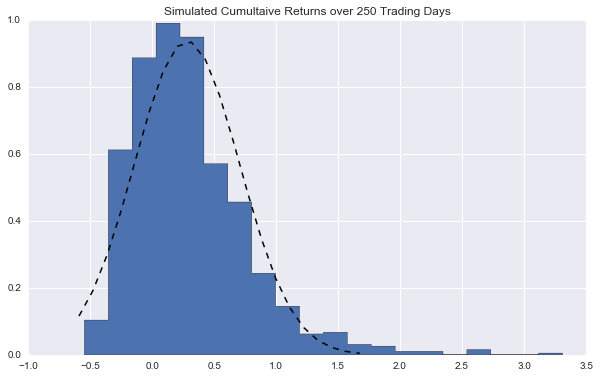

In [44]:
#PLOT RESULTS OF CUMULATIVE RETURN DISTRIBUTION
f, ax = plt.subplots(figsize=(10, 6))

pl.plot(bins,y,'k--',linewidth=1.5)
pl.title("Simulated Cumultaive Returns over 250 Trading Days")
mu = np.mean(cumrets)
sigma = np.std(cumrets)

n, bins, patches = pl.hist(cumrets, 20, normed=1, histtype='stepfilled')
y = pl.normpdf(bins,mu,sigma)

<H2>Exposure To Equity Markets<h2>

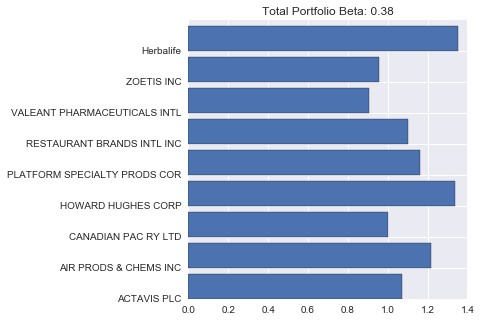

In [45]:
covmatrix = portTS2.cov()
covVsSP = covmatrix['SPX'].values
spvar = covVsSP[-1]
betas = [c / spvar for c in covVsSP ]
betas = betas[0:-1]
plt.subplots(figsize=(5,5))
N = len(betas)
plt.barh(np.arange(N),betas)
plt.yticks(np.arange(N),port['Name'])

Wm = np.matrix(w[0:len(betas)])
Bm = np.matrix(betas).transpose()
portBeta = (Wm * Bm)[0,0]
plt.title(str.format ("Total Portfolio Beta: {0:0.2}",portBeta))

<h2>Stock Selection</h2>
To test for the fund's stock selection/picking ability we conduct WSJ bull's dart test. 
We select 10 stocks at random (by throwing metaphorical darts) and calculate performance over the equally weighted portfoli of this stocks. We do this 10000 times and create the following plot. The distance of each point from the center is equal to the difference between that portfolio's return and max return obtained during simulation. The largest circle shows the portfolio that we are analyzing.



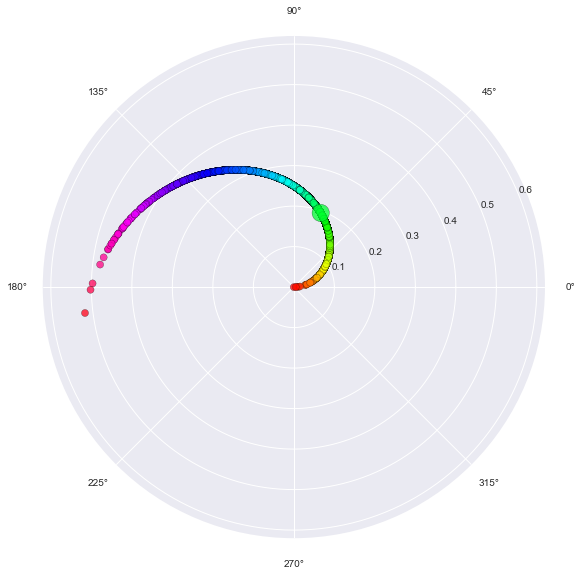

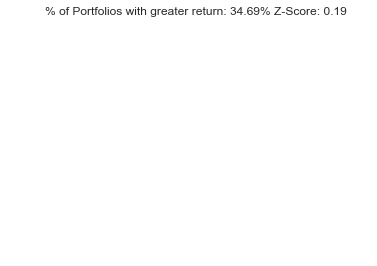

In [47]:
#first calculate portfolio cum return
act_ret =port_ts['2014-12-31':'2015-06-30']
cumrets = np.array([hf.calc_cumret(act_ret,i) for i in range(9)]) - 1
c = np.matrix(cumrets)
port_prof_ret = (W * c.T)[0,0]


stocks = pd.DataFrame.from_csv("data/stocks_500.csv")
symbols = np.array(stocks.index)
rets = stocks['Ret']
stockdict = dict(zip(symbols,rets))

def calc_trial_return(symbols, stockdict):
    """
        function to calculte return from single trial
    """
    np.random.shuffle(symbols)
    top10 = symbols[:10]
    top10rets = np.array([stockdict[sym] for sym in top10])
    return top10rets.mean();

trials = 10000
portrets = [calc_trial_return(symbols, stockdict) for i in range(trials)]
#signs = np.sign(np.random.rand(trials+1)-0.5)
portrets = np.append(portrets,port_prof_ret)
max_ret = portrets.max()
underperf = max_ret - portrets

betterreturns = portrets[portrets > port_prof_ret]

#stdndardize underperforming port returns for display
mu = underperf.mean()
sig = underperf.std()


r = underperf
#highest return is the bull's eye

theta = 2 * np.pi * r # np.random.rand(trials+1)
area = np.ones(trials+1)* 50
area[-1] =300
colors = theta
f,a = plt.subplots(figsize=(9,9))
ax = plt.subplot(111, polar=True)
c = plt.scatter(theta, r, c=colors, s=area, cmap=plt.cm.hsv)
c.set_alpha(0.75)

plt.show()
plt.axis('off')
plt.title(str.format("% of Portfolios with greater return: {0:0.2%} Z-Score: {1:0.2}",len(betterreturns)/trials,r[-1]))
ax.axes.get_yaxis().set_visible(False)




<h2>Other Analysis</h2>
Other Analysis that can be performed on this portfolio:
<ul>
<li>Liquidity analysis (requires average 90 day trading volume data)</li>
<li>Stress Test - apply different scenario shocks to each stock</li>
<li>Position overlap analysis - requires another equity portfolio </li>
</ul>